# Match up ARGO and WOD data

Additional data quality check using World Ocean Database 2018 (bottle and CTD-O2) measurements

- ARGO O2 profiles are screened with deep ocean (+1000m) climatology. 
- Float sensors (adjusted O2) with RMSE > 10 uM is removed from the analysis
- Co-locate ARGO and WOD profiles within 3 x 3 degree grid cell within the same month
- Profile difference is computed for every match-up profiles
- Mean bias and 95% confidence interval is calculated

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy import interpolate as itp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [15]:
# generate index for downloaded synthetic profiles
fn=pd.read_csv('available_floats.txt',header=None,names=['file'])
#print(np.size(fn))
#print(np.size(calib_ind))

In [16]:
# Only process known calibration types
df1=pd.read_csv('float_Type1_summary_ver.Feb1.csv')
df2=pd.read_csv('float_Type2_summary_ver.Feb1.csv')
df3=pd.read_csv('float_Type3_summary_ver.Feb1.csv')

In [17]:
res=3.0
#
# prepare grid cells
xW=np.arange(-180,180,res)
yS=np.arange(-90,90,res)
xC=np.arange(-180,180,res)+res/2
yC=np.arange(-90,90,res)+res/2
xE=np.arange(-180,180,res)+res
yN=np.arange(-90,90,res)+res
# time axis
Y=np.arange(2010,2020,1)
M=np.arange(1,13,1)
time=np.arange('2010-01','2020-01',dtype='datetime64[M]')
# empty array
Nx=np.size(xC)
Ny=np.size(yC)
#
z=[   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,  200.,
        250.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100.,
       1200., 1300., 1400., 1500., 1750., 2000., 2500., 3000., 3500., 4000.,
       4500., 5000., 5500.]

In [18]:
dswod=xr.open_dataset('wod_o2_binned_'+str(int(res))+'.nc')

In [19]:
# define helper function
def bin_doxy_adjusted(df,n): 
    fn0=df['File'][n]
    # prep empty array
    mn=np.empty((12*np.size(Y),26,Ny,Nx)) # stat mean
    sd=np.empty((12*np.size(Y),26,Ny,Nx)) # stdev
    dd=np.empty((12*np.size(Y),26,Ny,Nx)) # count
    # read in the data
    print('reading in '+fn0)
    ds=xr.open_dataset(fn0)
    Ns=np.shape(ds['O2_FLT_ADJUSTED']) # profile, depth
    date=ds['JULD']
    loctime=pd.to_datetime(date)
    long=ds['LONGITUDE'].to_numpy()
    lati=ds['LATITUDE'].to_numpy()
    z0=ds['depth']
    for p in range(0,Ns[0]):
        if pd.notna(loctime[p]) & pd.notna(long[p]) & pd.notna(lati[p]):
            if long[p]<180:
                x0=long[p]
            else:
                x0=long[p]-360
            #
            y0=lati[p]
            o2=ds['O2_FLT_ADJUSTED'][p,:]
            yr=int(loctime[p].year)
            mo=int(loctime[p].month)
            itime=mo+12*(yr-2010)
            ix=np.where((x0>=xW)&(x0<xE))
            iy=np.where((y0>=yS)&(y0<yN))
            if (itime>0)&(itime<120):
                for k in range(0,26):
                    if (np.isnan(o2[k])==False):
                        mn[itime,k,iy,ix]=np.squeeze(mn[itime,k,iy,ix])+o2[k]
                        sd[itime,k,iy,ix]=np.squeeze(sd[itime,k,iy,ix])+o2[k]**2
                        dd[itime,k,iy,ix]=np.squeeze(dd[itime,k,iy,ix])+1
    mn=mn/dd
    sd=np.sqrt(sd/dd-mn**2)
    da1=xr.DataArray(data=mn,name='o2_mn',
                 dims=['time','depth','lat','lon'],
                 coords={'lon':xC,'lat':yC,'depth':z[:26],'time':time})
    ds=da1.to_dataset()
    da1=xr.DataArray(data=sd,name='o2_sd',
                 dims=['time','depth','lat','lon'],
                 coords={'lon':xC,'lat':yC,'depth':z[:26],'time':time})
    ds['o2_sd']=da1
    da1=xr.DataArray(data=dd,name='o2_dd',
                 dims=['time','depth','lat','lon'],
                 coords={'lon':xC,'lat':yC,'depth':z[:26],'time':time})
    ds['o2_dd']=da1
    return ds

In [20]:
def match_diff(df,m,wd0):
    dsflt=bin_doxy_adjusted(df,m)
    wmoid=df['WMO ID'][m]
    #
    # matching (-dsflt.o2_mn + dswod.o2_mn) would be nan if there is no match
    o2diff=(dsflt.o2_mn - dswod.o2_mn)
    # generate vertical profiles
    imatch=np.where(~np.isnan(o2diff.mean('depth')))
    Nmatch=np.size(imatch[0])
    print('There is '+str(Nmatch)+' matching prfiles')
    # 
    o2diff_profiles=np.empty((Nmatch,26))
    xloc=np.empty(Nmatch,dtype=int)
    yloc=np.empty(Nmatch,dtype=int)
    tloc=np.empty(Nmatch,dtype=int)
    #
    for n in range(Nmatch):
        # take the profile difference
        tmp=o2diff[imatch[0][n],:,imatch[1][n],imatch[2][n]]
        tloc[n]=int(imatch[0][n])
        yloc[n]=int(imatch[1][n])
        xloc[n]=int(imatch[2][n])
        o2diff_profiles[n,:]=tmp
        # plot the data
        fig, axes = plt.subplots(ncols=2)
        dswod['o2_mn'][tloc[n],:,yloc[n],xloc[n]].plot(y='depth',label='WOD',ax=axes[0],ylim=(2000,0))
        dsflt['o2_mn'][tloc[n],:,yloc[n],xloc[n]].plot(y='depth',label='WMOID='+str(wmoid),ax=axes[0])
        axes[0].legend()
        tmp.plot(y='depth',ylim=(2000,0))
        axes[1].set_xlabel('o2 diff. micro-mol/kg')
        axes[1].set_title('(ARGO - WOD)')
        wn=wd0+'/res'+str(res)+'wmoid'+str(wmoid)+'prof'+str(n)+'.pdf'
        fig.savefig(wn,bbox_inches="tight",dpi=300)
    return o2diff_profiles,xloc,yloc,tloc,wmoid

reading in compare_woa_v3/1901134_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1901135_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/1901152_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1901153_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1901154_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/1901155_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1901156_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1901157_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1901158_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1901159_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/1901338_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1901339_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1901379_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 4 matching prfiles
reading in compare_woa_v3/1901467_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/1901468_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1902303_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1902304_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900128_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2901551_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2901555_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2901559_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2901562_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2901563_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902086_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902088_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/2902090_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902092_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902093_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/2902114_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902115_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/2902118_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/2902120_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902124_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902130_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902131_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902158_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/2902174_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902177_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902205_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902245_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902263_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/2902264_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3900333_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3900334_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3900344_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3900345_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3900346_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3900347_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3900348_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3900534_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3900727_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3900729_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3901075_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3901076_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3901078_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3901079_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3901080_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3901466_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3901999_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3902114_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3902126_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3902127_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/3902128_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3902130_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/3902132_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/4900093_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/4900482_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/4901216_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 6 matching prfiles


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/3019285349.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2)


reading in compare_woa_v3/4901460_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/4903365_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5900420_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5900421_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5900422_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5900841_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5900952_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5900966_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901043_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901044_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901048_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901050_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901051_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901052_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901054_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901071_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901072_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901165_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901178_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901187_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901188_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901337_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901369_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901457_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901459_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901460_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901461_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901462_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901463_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901466_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901467_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901644_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5901645_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901646_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901647_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901648_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5901696_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901697_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901699_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5901733_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901734_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5901736_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901744_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5902100_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5902101_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5902110_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903218_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903226_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903242_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/5903255_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/5903256_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903257_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5903258_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/5903259_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/5903260_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903264_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5903385_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 17 matching prfiles
reading in compare_woa_v3/5903629_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903649_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5903656_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 4 matching prfiles
reading in compare_woa_v3/5903678_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903679_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5903741_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 6 matching prfiles
reading in compare_woa_v3/5903888_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 3 matching prfiles
reading in compare_woa_v3/5903939_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5903954_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903956_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/5903957_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904036_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5904089_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 3 matching prfiles
reading in compare_woa_v3/5904090_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904091_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904092_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904093_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 3 matching prfiles
reading in compare_woa_v3/5904094_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 6 matching prfiles
reading in compare_woa_v3/5904126_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 20 matching prfiles
reading in compare_woa_v3/5904227_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904475_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904477_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904479_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904598_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5904670_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904672_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904673_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904767_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904768_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904847_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904882_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904983_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5904984_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905023_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905165_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5905194_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905198_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905396_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905397_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905988_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 4 matching prfiles
reading in compare_woa_v3/5905996_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906305_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906306_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906307_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906308_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906309_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906310_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906311_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906623_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906635_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906636_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906645_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6900526_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6900527_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6900531_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6900627_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6900628_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6900630_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6900764_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6900791_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6900792_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6900889_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6900890_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/6900944_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901457_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901458_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901461_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901468_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901486_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 3 matching prfiles
reading in compare_woa_v3/6901597_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901604_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901646_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901756_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902549_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/6902686_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902701_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902736_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/6902740_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/6902742_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902743_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902805_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902808_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902810_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902880_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902906_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902907_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902908_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902909_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902972_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902973_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902974_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902975_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902978_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902979_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902982_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902983_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902984_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903024_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903025_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903028_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903032_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903034_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903035_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903039_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903041_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903066_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903067_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903070_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903071_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903080_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903081_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903082_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903083_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903085_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903086_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903091_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903096_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903190_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903191_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903204_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/6903225_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/6903233_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903267_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903273_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/6903552_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903556_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903575_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903577_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903582_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903777_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903870_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903871_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903872_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903873_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903874_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903875_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903876_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903877_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6904113_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/7900585_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles


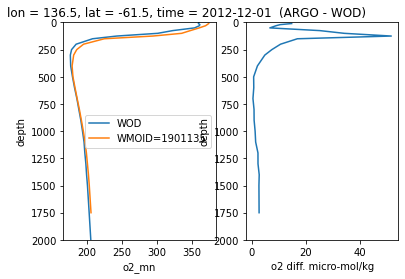

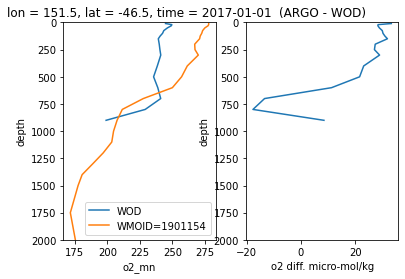

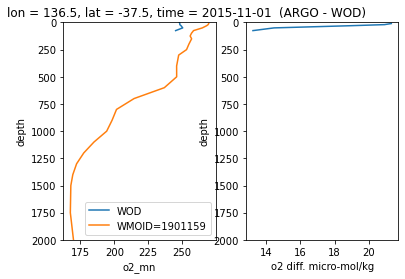

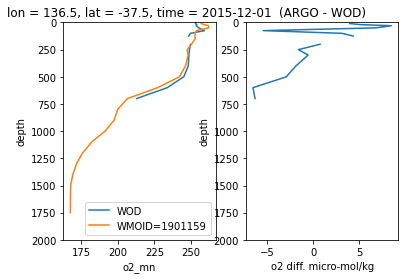

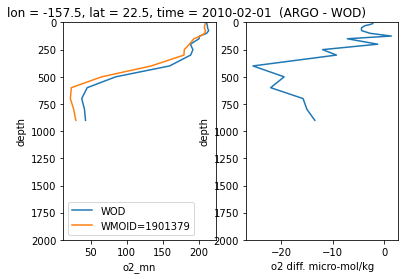

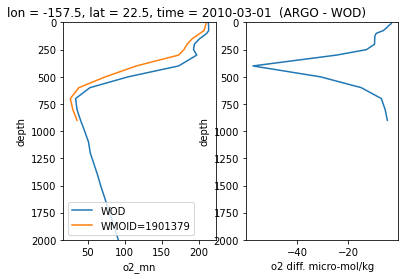

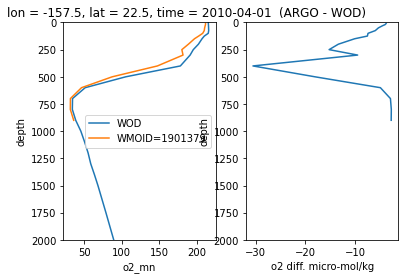

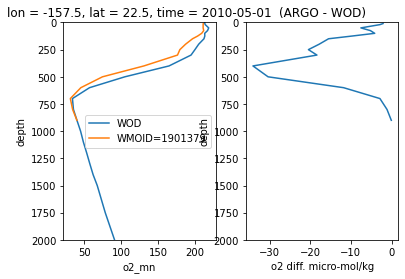

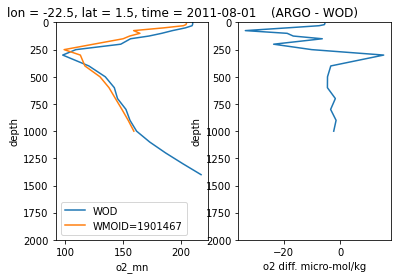

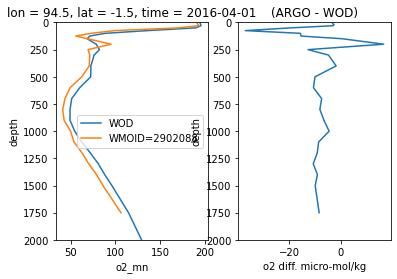

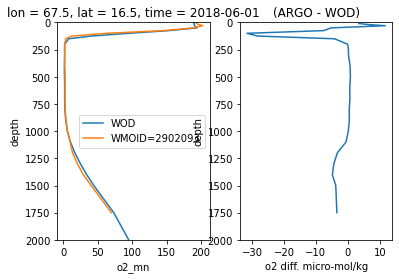

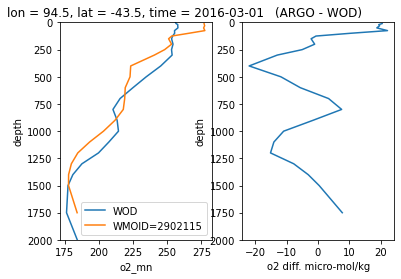

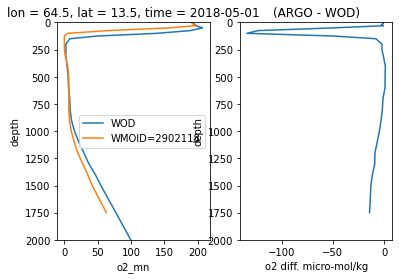

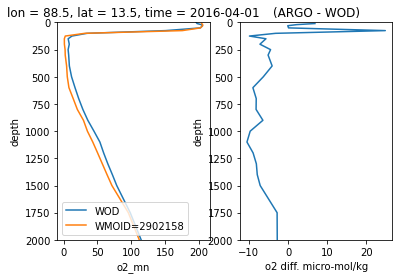

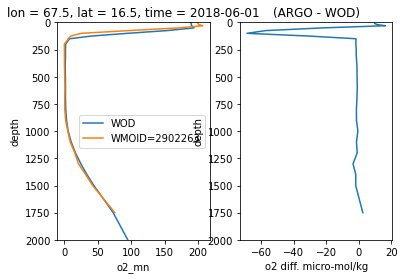

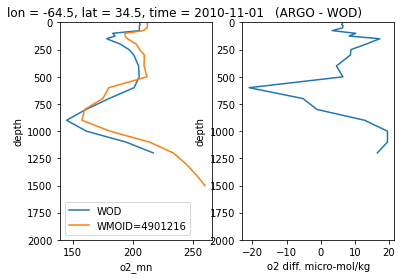

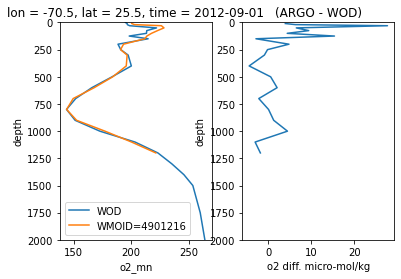

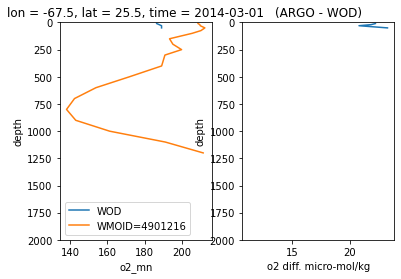

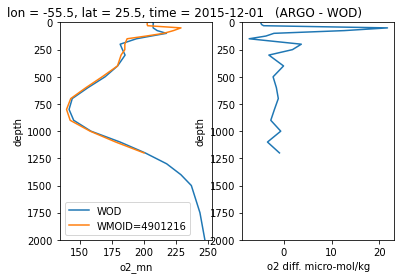

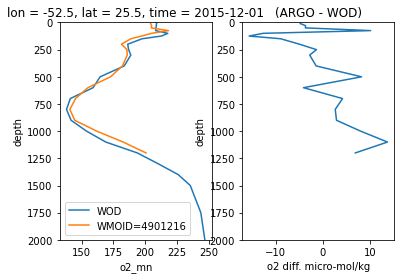

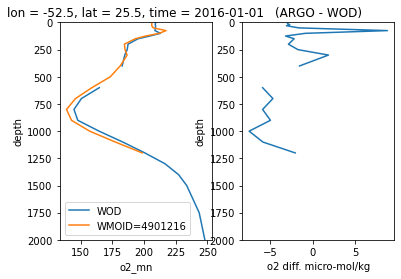

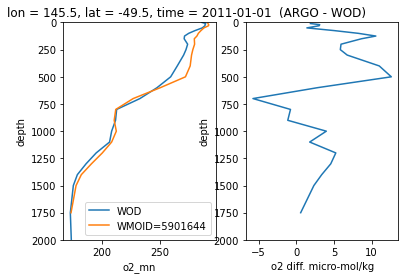

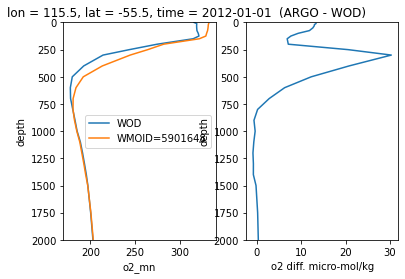

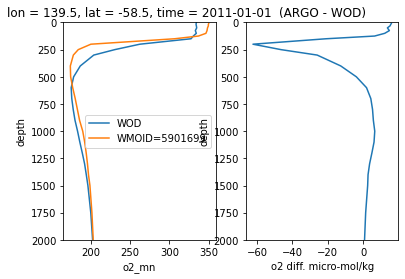

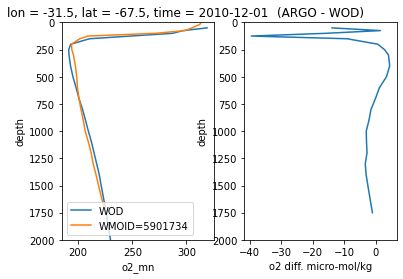

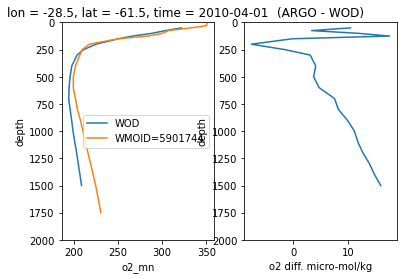

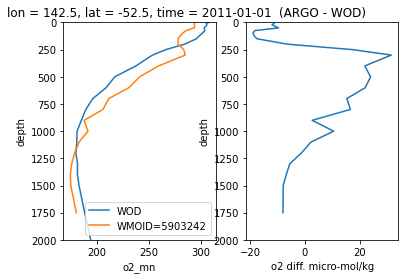

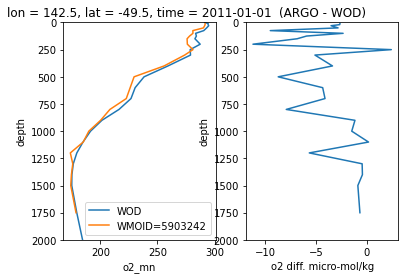

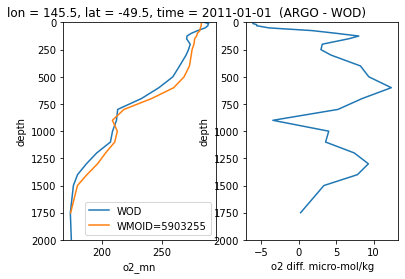

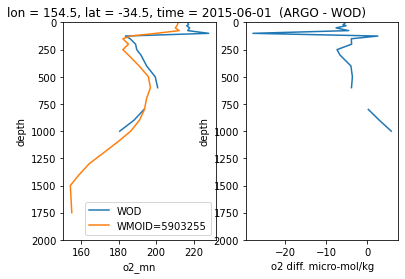

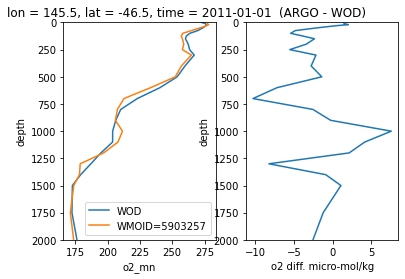

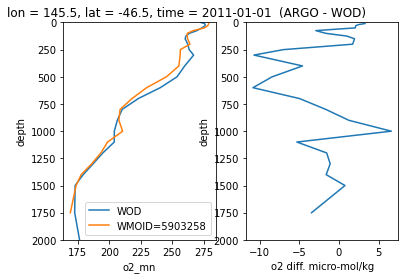

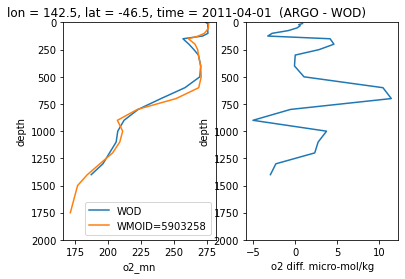

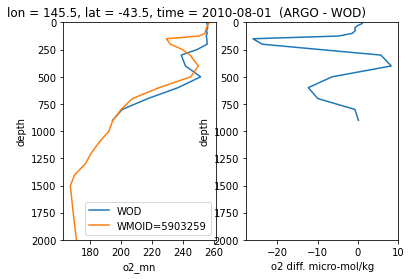

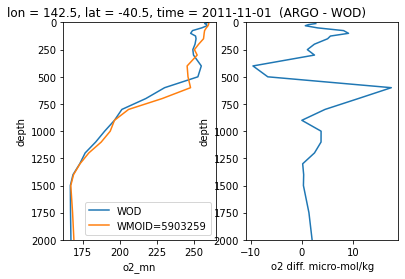

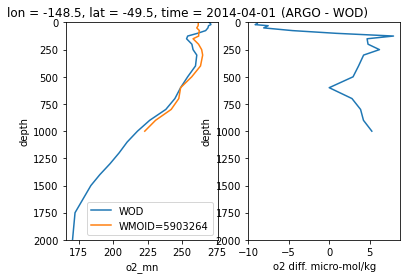

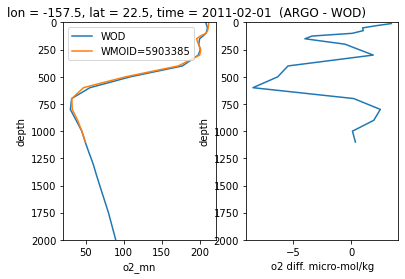

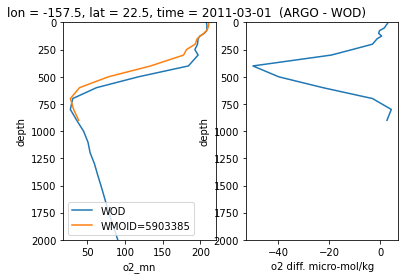

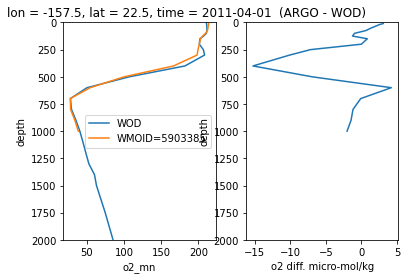

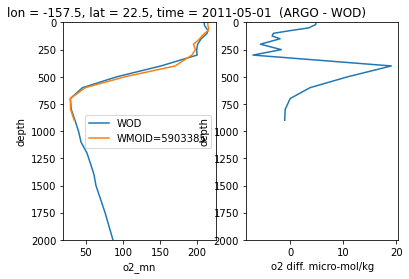

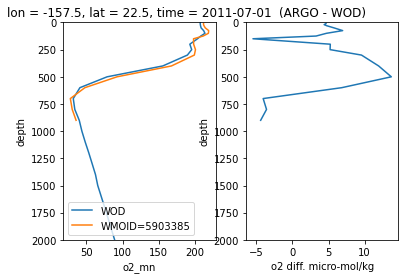

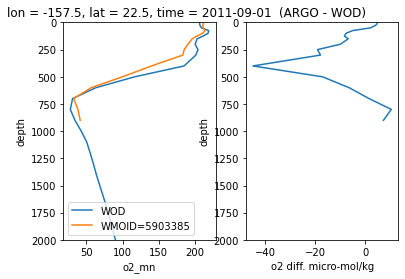

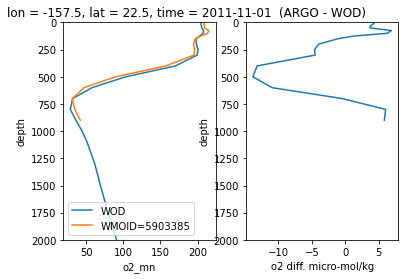

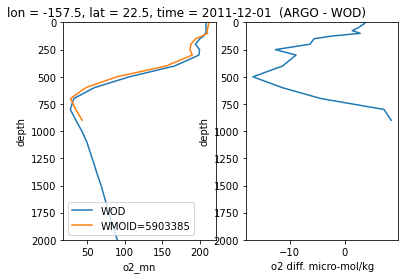

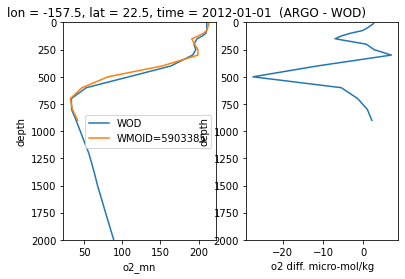

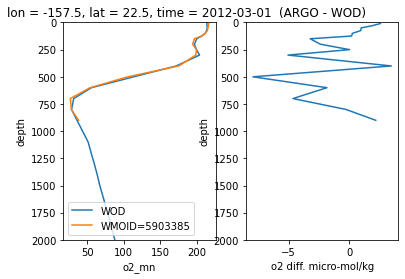

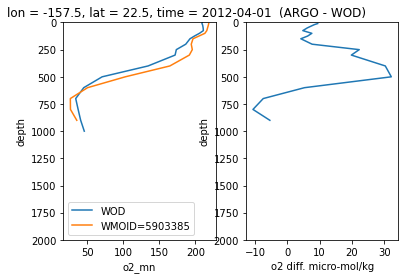

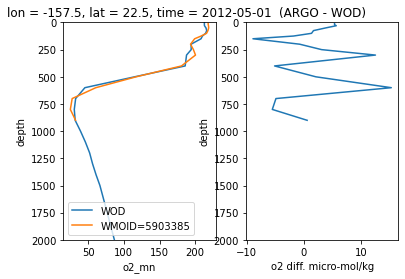

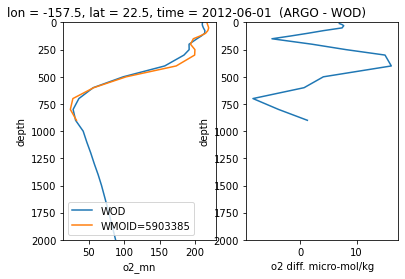

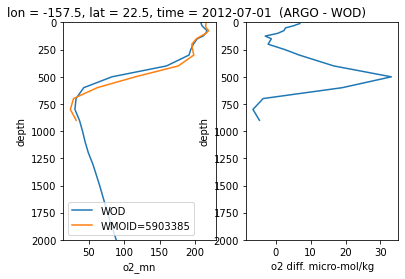

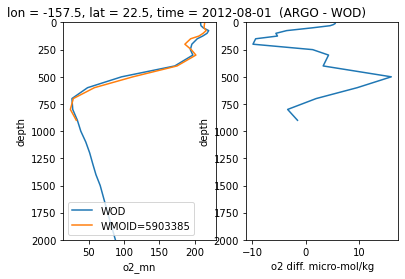

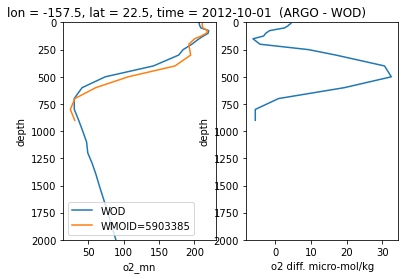

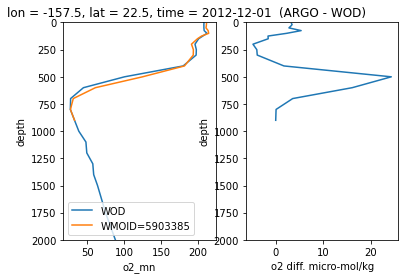

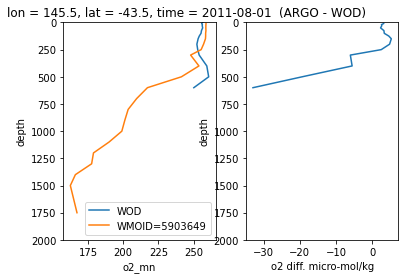

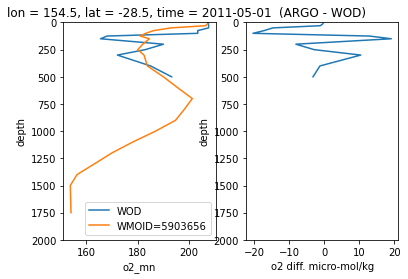

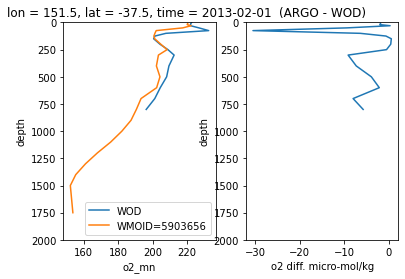

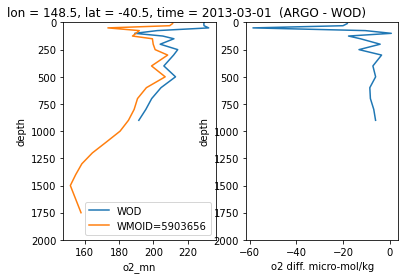

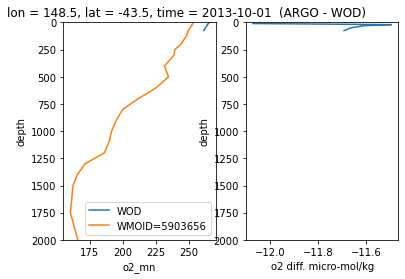

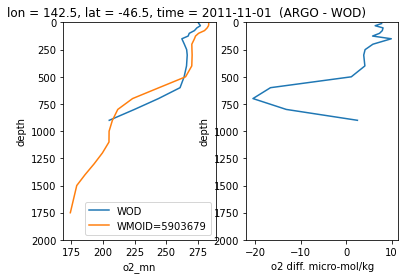

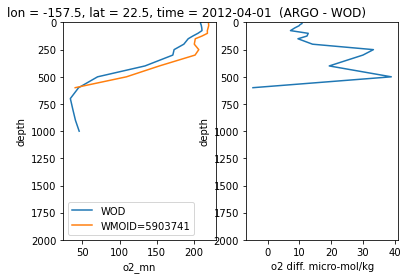

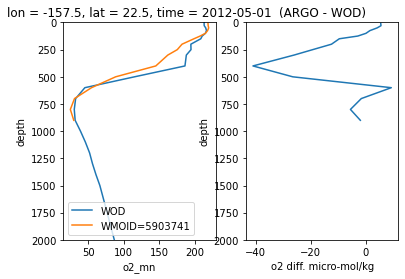

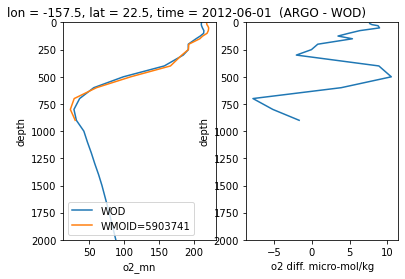

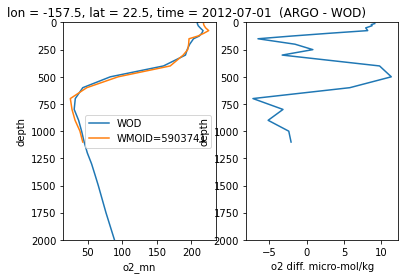

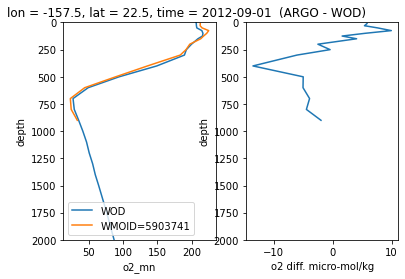

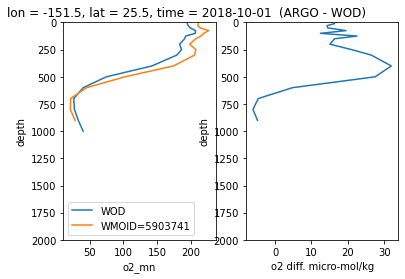

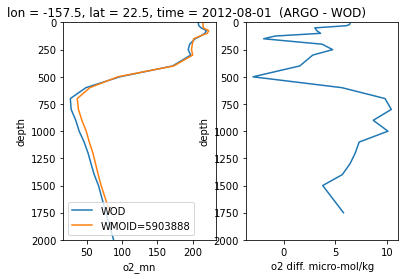

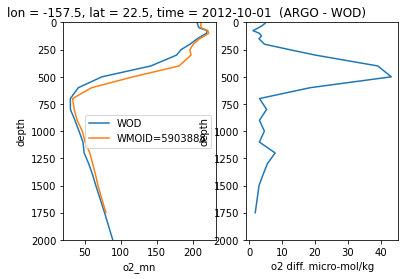

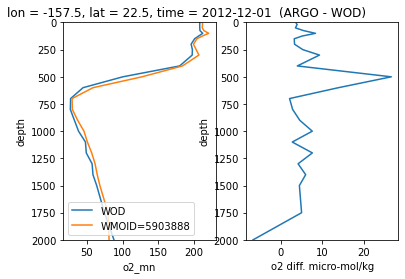

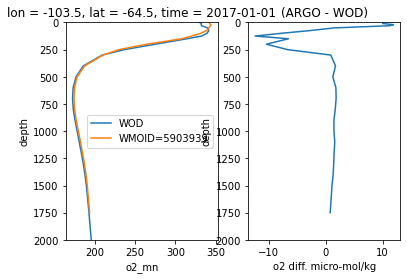

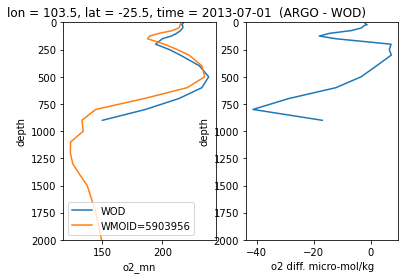

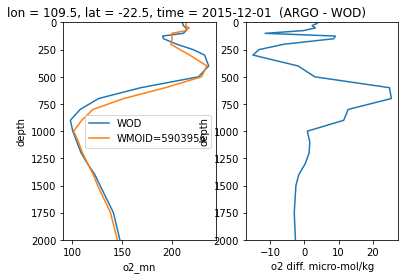

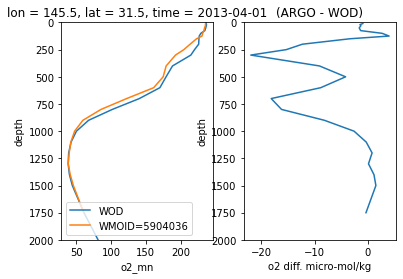

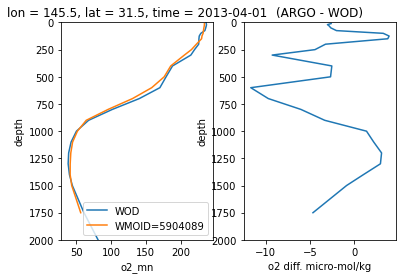

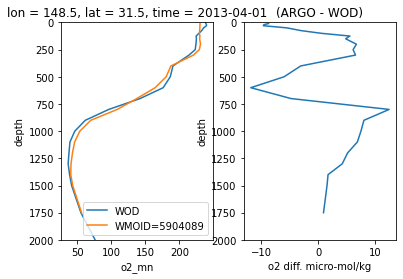

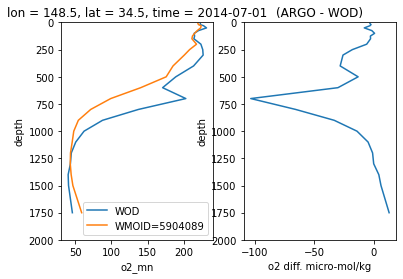

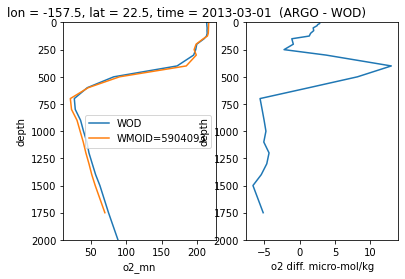

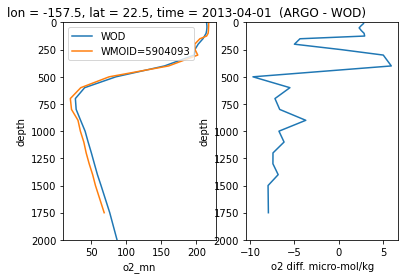

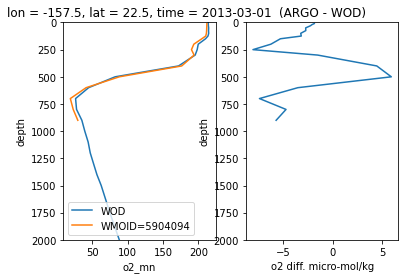

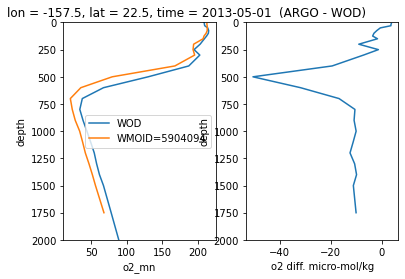

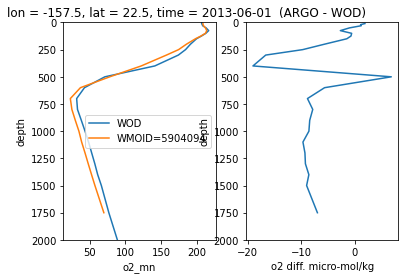

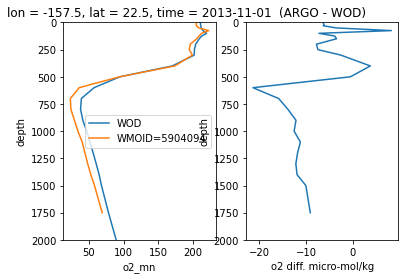

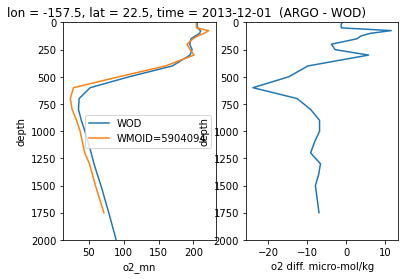

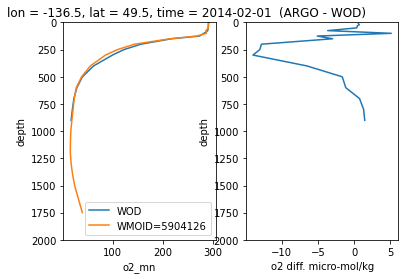

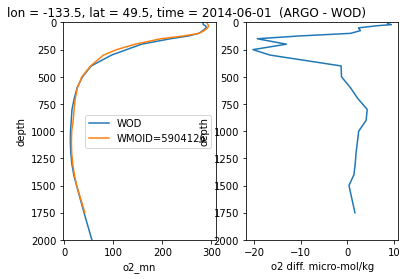

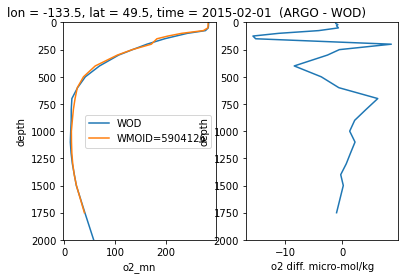

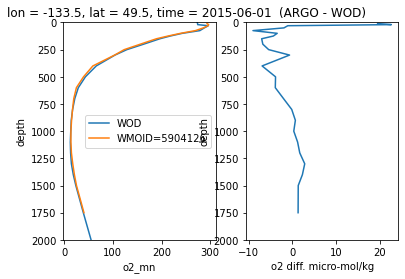

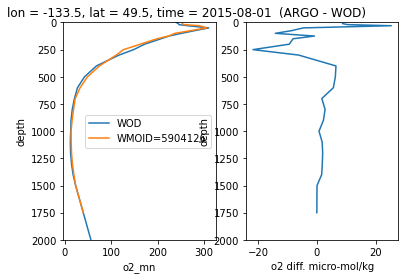

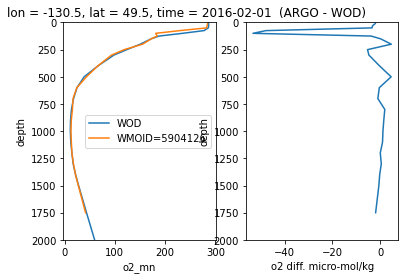

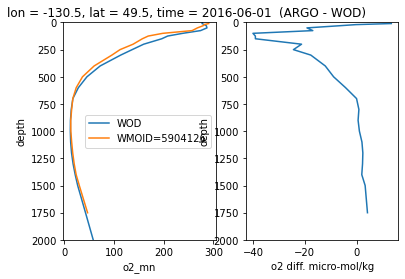

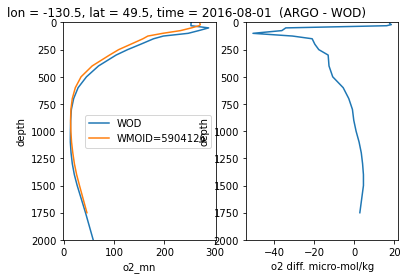

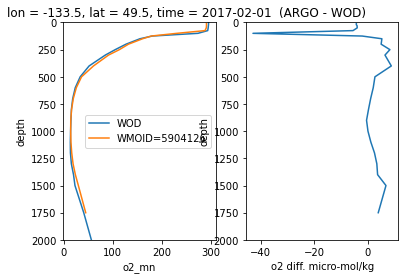

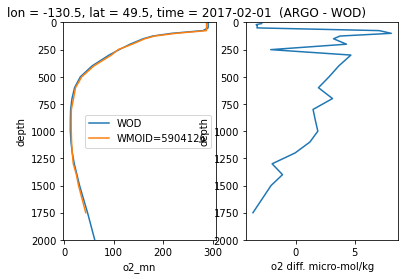

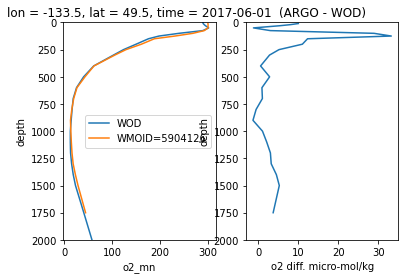

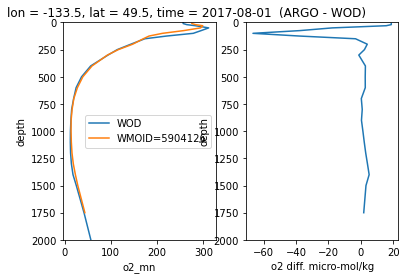

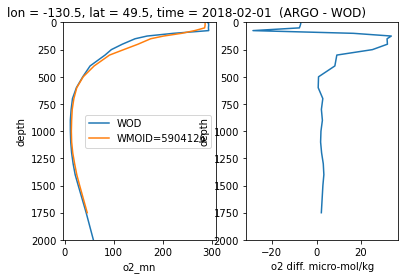

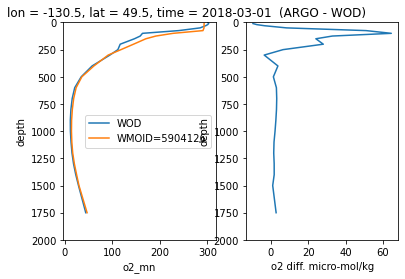

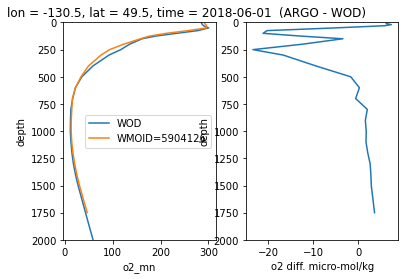

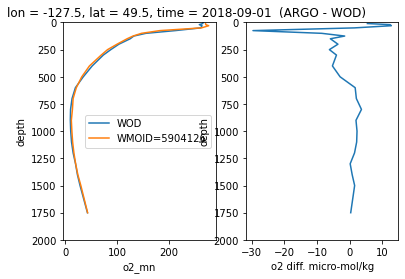

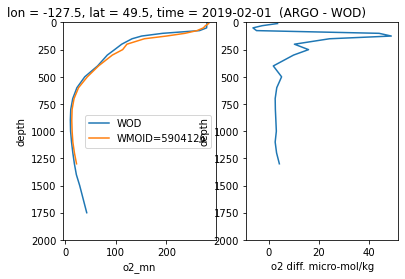

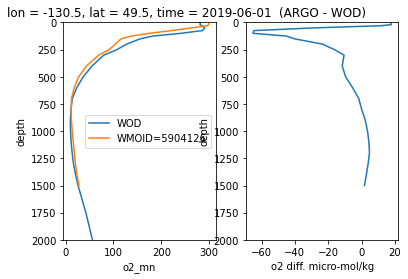

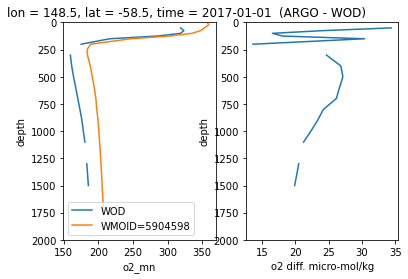

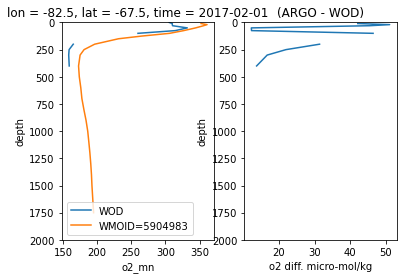

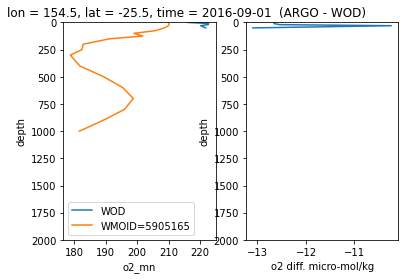

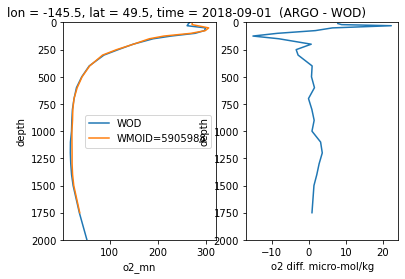

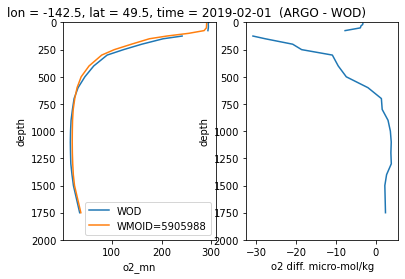

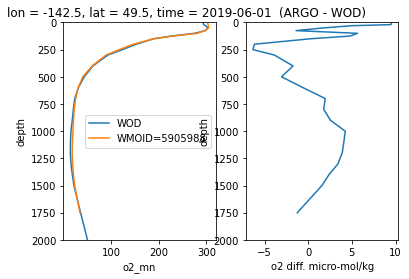

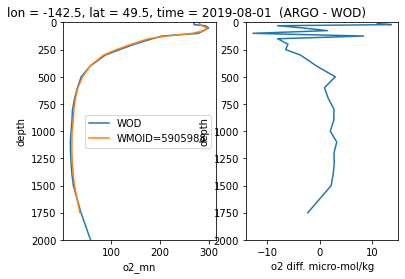

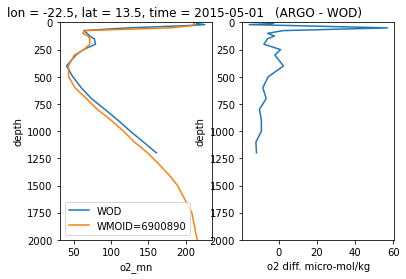

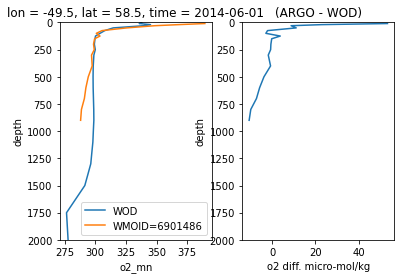

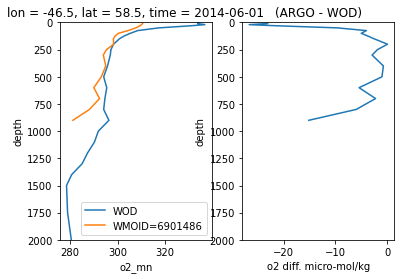

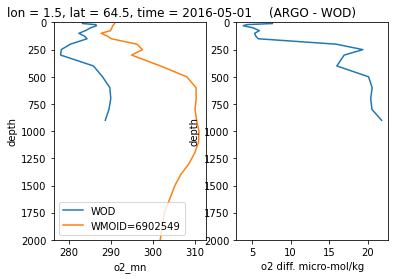

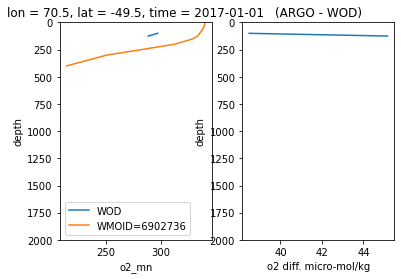

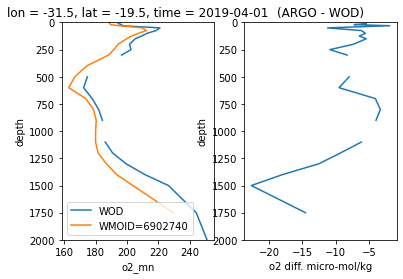

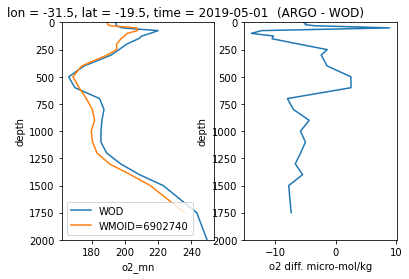

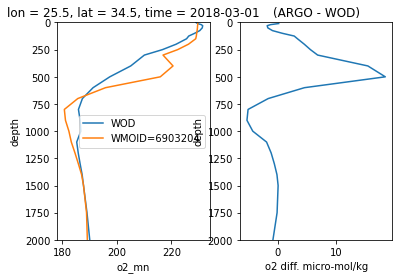

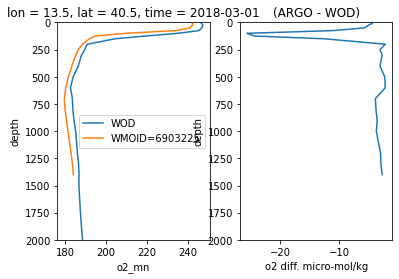

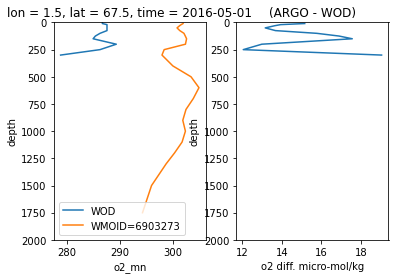

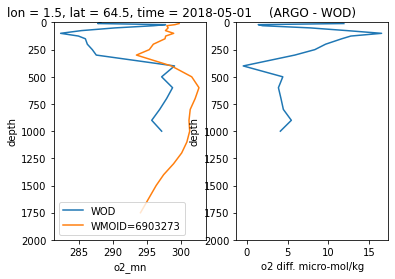

In [21]:
# match up profiles for type 1 calibration
Nty=df1.shape
o2d=np.zeros((1000,26))
Xind=[]
Yind=[]
Tind=[]
wmoid_checked=np.zeros(1000,dtype='int')
rmse=np.zeros(1000)
Ncum=0
wd0='fig_type1_matchup'
! mkdir -p fig_type1_matchup
#
for m in range(Nty[0]):
    o2diff_profiles,xloc,yloc,tloc,wmoid=match_diff(df1,m,wd0)
    Nm=np.size(xloc)
    if Nm >= 1:
        Xind.append(xloc)
        Yind.append(yloc)
        Tind.append(tloc)
        o2d[Ncum:Ncum+Nm,:]=o2diff_profiles
        rmse[Ncum:Ncum+Nm]=np.sqrt(np.nanmean(o2diff_profiles**2))
        wmoid_checked[Ncum:Ncum+Nm]=wmoid
        Ncum=Ncum+Nm

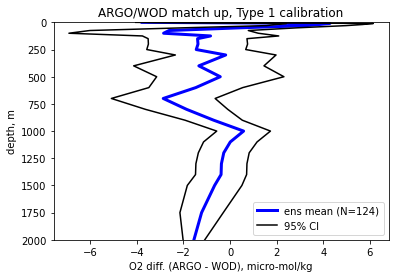

In [22]:
# save the match up results
da=xr.DataArray(data=o2d[:Ncum,:],name='o2_diff',
                dims=['profile','depth'],
               coords={'profile':range(Ncum),'depth':z[:26]})
ds=da.to_dataset()
ds.to_netcdf('Type1_matchup_o2diff.nc')
#
y=np.nanmean(o2d[:Ncum,:],axis=0)
ysd=np.nanstd(o2d[:Ncum,:],axis=0)
p0=plt.plot(y,z[:26],c='b',linewidth=3)
p1=plt.plot(y+2*ysd/np.sqrt(Ncum),z[:26],c='k')
plt.plot(y-2*ysd/np.sqrt(Ncum),z[:26],c='k')
plt.ylim(2000,0)
plt.xlabel('O2 diff. (ARGO - WOD), micro-mol/kg')
plt.ylabel('depth, m')
plt.legend([p0[0],p1[0]],['ens mean (N='+str(Ncum)+')','95% CI'])
plt.title('ARGO/WOD match up, Type 1 calibration')
plt.savefig('wod_matchup_type1.pdf',bbox_inches="tight",dpi=300)
plt.show()

reading in compare_woa_v3/1901360_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1901361_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/1901363_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/1901364_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/1901365_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/3902123_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/4900497_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903593_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904027_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 3 matching prfiles
reading in compare_woa_v3/5904124_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 3 matching prfiles
reading in compare_woa_v3/5904147_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904172_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904188_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904395_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904396_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904397_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904464_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904465_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904467_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5904468_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904469_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5904470_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 3 matching prfiles
reading in compare_woa_v3/5904471_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904484_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904485_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904486_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904487_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904600_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904601_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904602_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904655_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904659_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5904674_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904675_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904678_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904685_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904691_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904693_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904694_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904761_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904763_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904764_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904765_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904769_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5904841_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904842_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904843_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904844_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5904849_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904850_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904851_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904852_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904853_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904855_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/3019285349.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2)


reading in compare_woa_v3/5904856_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5904857_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904859_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904860_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904980_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5904981_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5905067_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905069_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905070_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905076_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905077_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905078_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5905091_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5905092_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905093_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905094_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905095_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/5905096_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905097_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5905099_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905100_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905101_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905102_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905103_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905104_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905106_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905107_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905108_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905109_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905111_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905113_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905130_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905132_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905139_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905368_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905369_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905370_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905372_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905374_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5905375_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5905377_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905378_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905379_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905380_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905382_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905383_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905634_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905635_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905636_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905637_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905638_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905639_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905969_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905970_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905971_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905972_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905973_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905974_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905975_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905977_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905980_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905981_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905983_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5905985_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905986_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905991_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905992_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905993_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905994_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905997_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5905998_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906000_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906003_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906005_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906006_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906007_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5906008_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906018_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906019_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906020_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906021_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906027_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906028_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906030_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906031_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906033_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906034_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906039_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906040_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906041_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906043_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906044_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906045_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906046_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906201_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906202_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906203_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906204_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906207_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906211_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906212_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906213_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906222_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906224_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906225_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906227_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906228_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906235_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906236_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906237_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906238_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906243_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906293_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906294_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906296_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906300_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906301_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906302_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906303_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906313_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906317_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906318_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906319_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906339_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5906440_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902734_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/6902739_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902800_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902873_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902874_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902900_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903026_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903246_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903550_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903551_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903553_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903554_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903558_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903567_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903568_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903569_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903572_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903573_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6903574_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6904110_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6904111_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6904112_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6904114_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6904115_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles


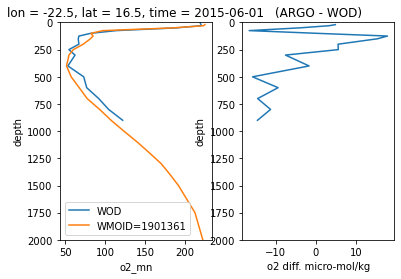

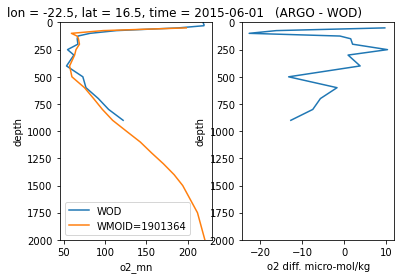

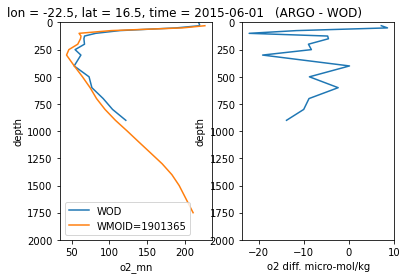

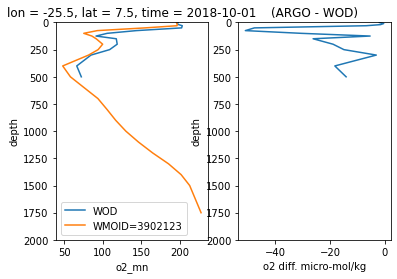

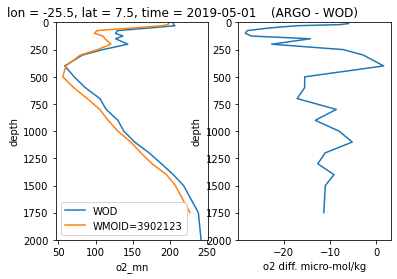

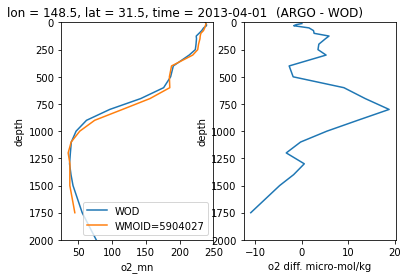

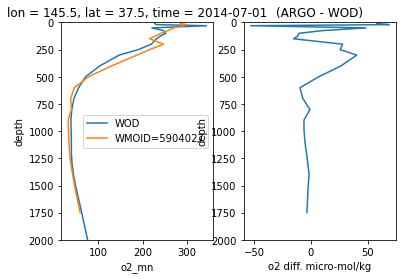

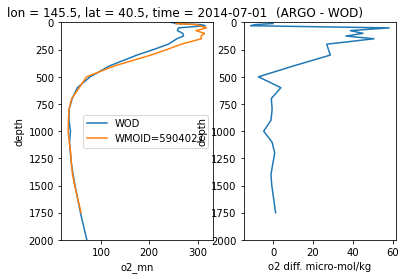

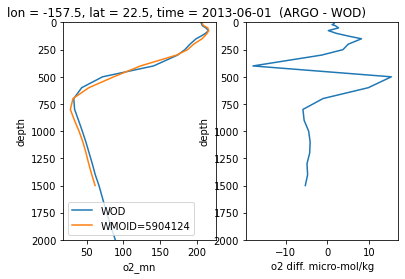

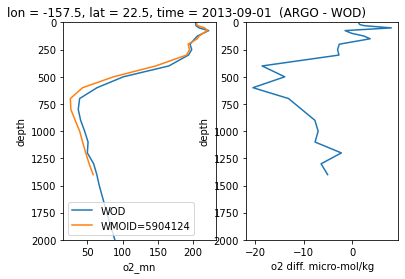

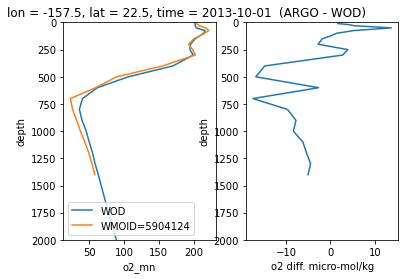

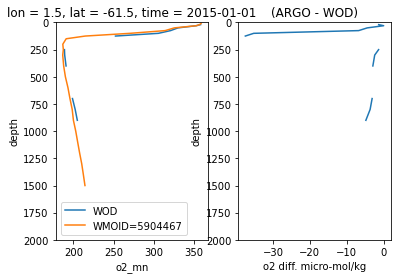

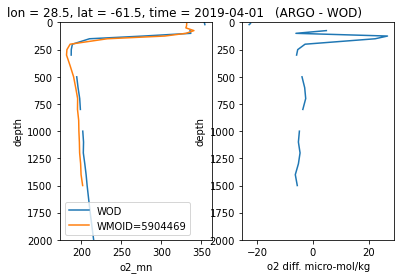

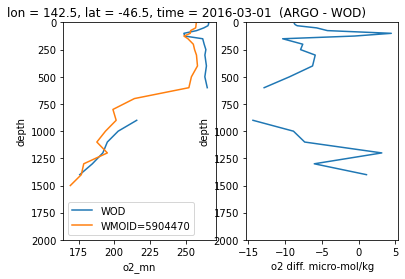

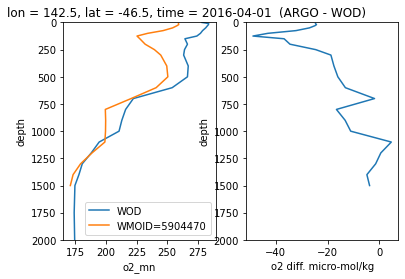

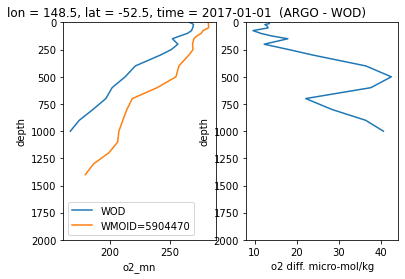

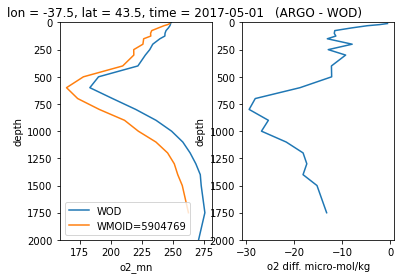

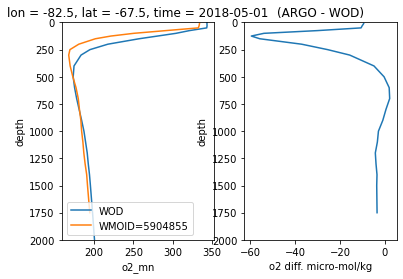

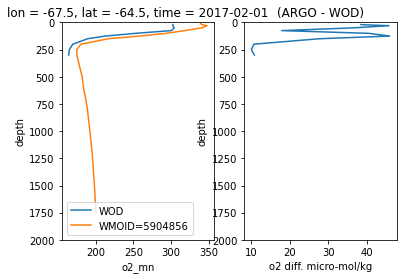

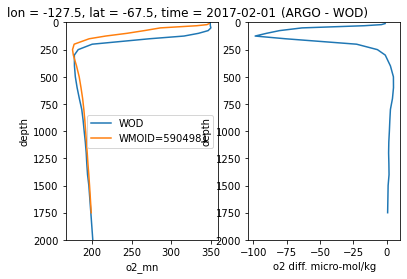

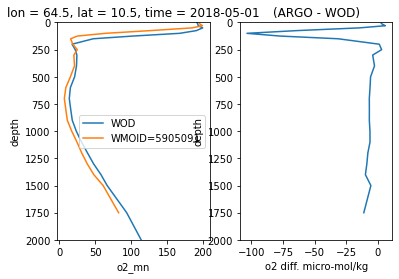

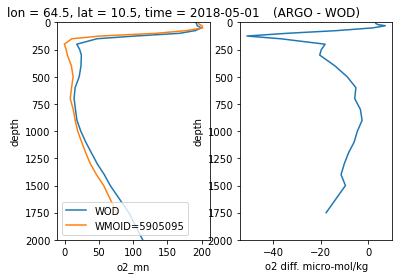

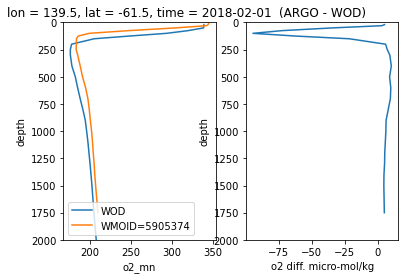

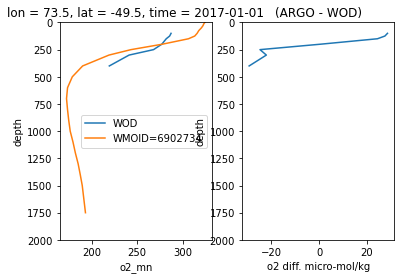

In [23]:
# match up profiles for type 2 calibration
Nty=df2.shape
o2d=np.zeros((1000,26))
Xind=[]
Yind=[]
Tind=[]
wmoid_checked=np.zeros(1000,dtype='int')
rmse=np.zeros(1000)
Ncum=0
wd0='fig_type2_matchup'
! mkdir -p fig_type2_matchup
#
for m in range(Nty[0]):
    o2diff_profiles,xloc,yloc,tloc,wmoid=match_diff(df2,m,wd0)
    Nm=np.size(xloc)
    if Nm >= 1:
        Xind.append(xloc)
        Yind.append(yloc)
        Tind.append(tloc)
        o2d[Ncum:Ncum+Nm,:]=o2diff_profiles
        rmse[Ncum:Ncum+Nm]=np.sqrt(np.nanmean(o2diff_profiles**2))
        wmoid_checked[Ncum:Ncum+Nm]=wmoid
        Ncum=Ncum+Nm

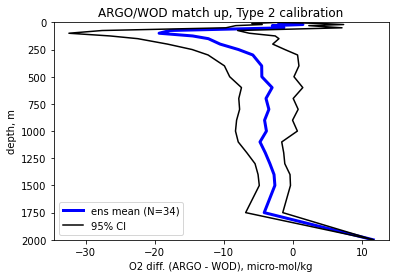

In [24]:
# save the match up results
da=xr.DataArray(data=o2d[:Ncum,:],name='o2_diff',
                dims=['profile','depth'],
               coords={'profile':range(Ncum),'depth':z[:26]})
ds=da.to_dataset()
ds.to_netcdf('Type2_matchup_o2diff.nc')
#
y=np.nanmean(o2d[:Ncum,:],axis=0)
ysd=np.nanstd(o2d[:Ncum,:],axis=0)
p0=plt.plot(y,z[:26],c='b',linewidth=3)
p1=plt.plot(y+2*ysd/np.sqrt(Ncum),z[:26],c='k')
plt.plot(y-2*ysd/np.sqrt(Ncum),z[:26],c='k')
plt.ylim(2000,0)
plt.xlabel('O2 diff. (ARGO - WOD), micro-mol/kg')
plt.ylabel('depth, m')
plt.legend([p0[0],p1[0]],['ens mean (N='+str(Ncum)+')','95% CI'])
plt.title('ARGO/WOD match up, Type 2 calibration')
plt.savefig('wod_matchup_type2.pdf',bbox_inches="tight",dpi=300)
plt.show()

reading in compare_woa_v3/1900722_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900114_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900115_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900117_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900118_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900119_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900120_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900123_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900124_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900125_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/2900126_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900127_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2900129_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902732_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902746_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902747_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902757_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902758_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902762_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902764_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902822_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/2902823_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/4900474_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/4900475_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/4900476_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/4900483_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/4900485_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/4900487_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/4901137_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 6 matching prfiles
reading in compare_woa_v3/5900965_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901045_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901046_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901047_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901073_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901310_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901313_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901314_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901315_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901316_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901317_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901336_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901338_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901339_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901370_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901372_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901373_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901444_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5901446_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5901448_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5901449_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901450_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5901452_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901453_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901454_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901455_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901456_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901465_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901491_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5901730_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901739_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5901740_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901741_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901742_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5901743_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5902099_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5902105_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5902113_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5902116_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5902117_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5902261_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5902300_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5902301_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5902302_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 5 matching prfiles


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/3019285349.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2)


reading in compare_woa_v3/5903382_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903615_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903616_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 1 matching prfiles
reading in compare_woa_v3/5903713_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903719_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903720_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5903722_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/5904924_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901023_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/6901025_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/6901027_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901593_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901595_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901602_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901603_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901627_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 2 matching prfiles
reading in compare_woa_v3/6901631_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901632_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901750_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901752_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901753_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901754_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901755_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901758_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6901759_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902802_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902806_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902807_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902819_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902869_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles
reading in compare_woa_v3/6902879_26lev.nc


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:37: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd
/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_39742/1136028667.py:38: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd-mn**2)


There is 0 matching prfiles


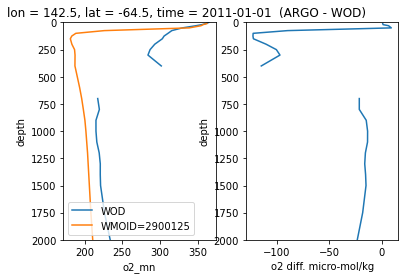

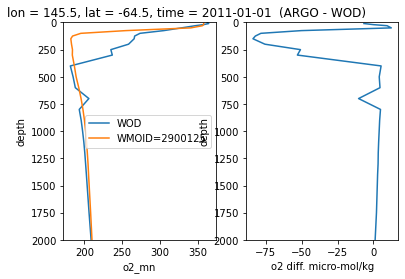

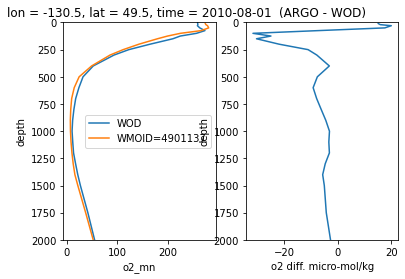

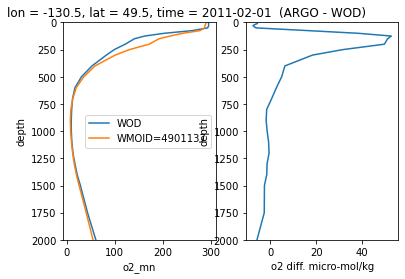

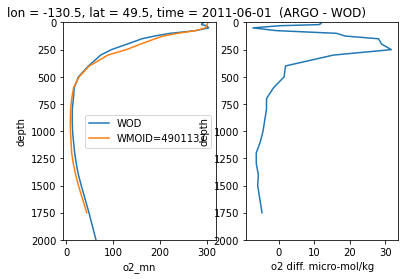

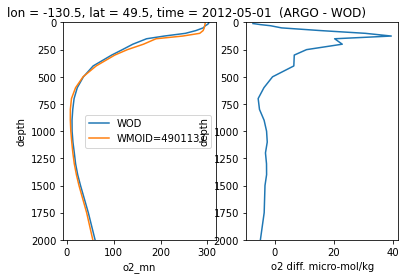

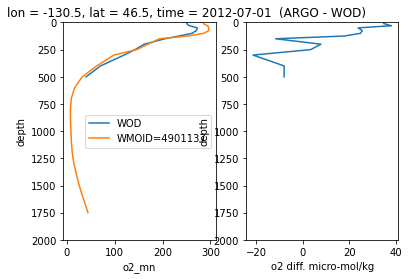

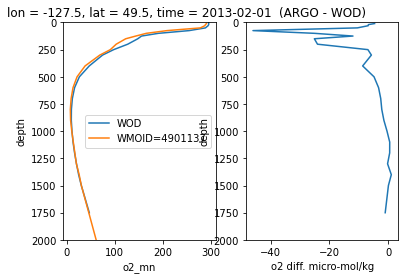

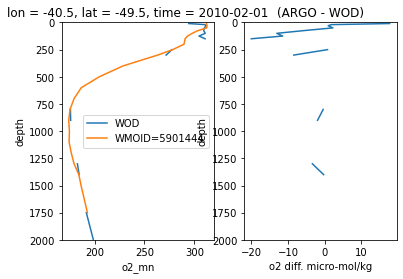

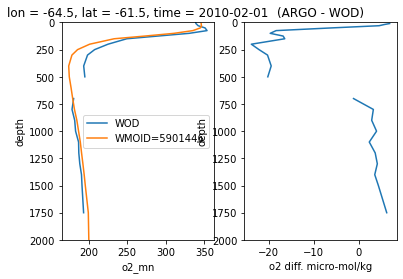

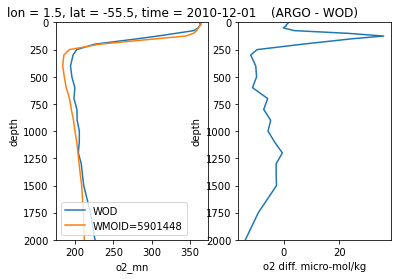

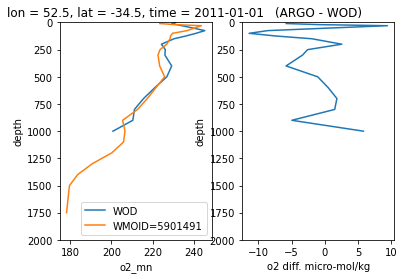

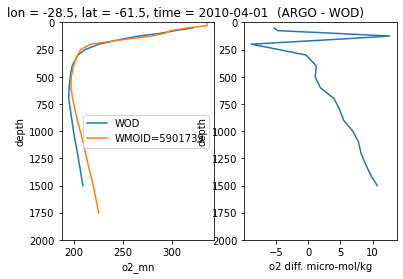

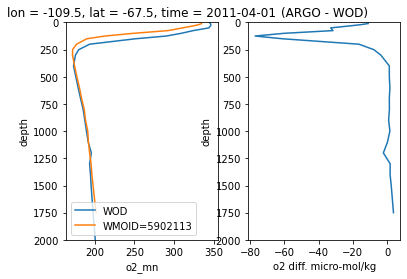

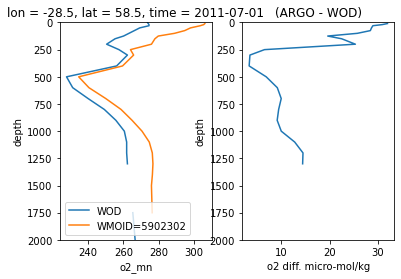

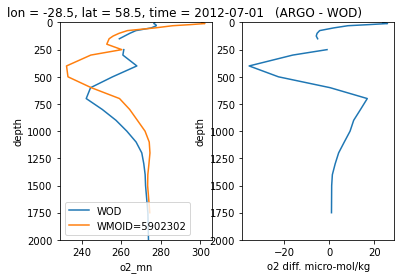

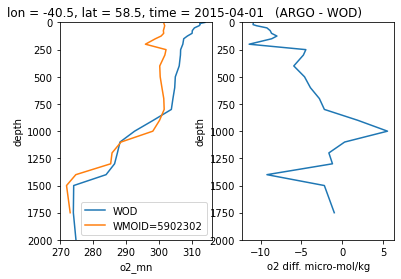

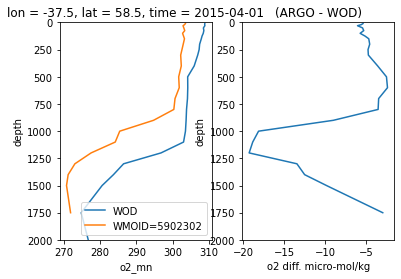

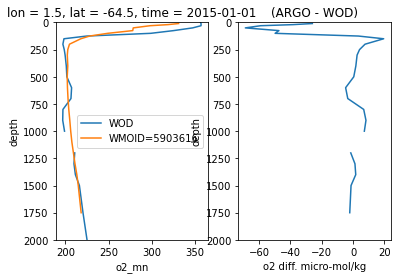

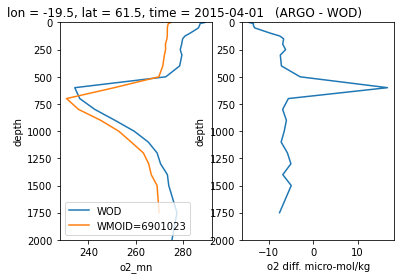

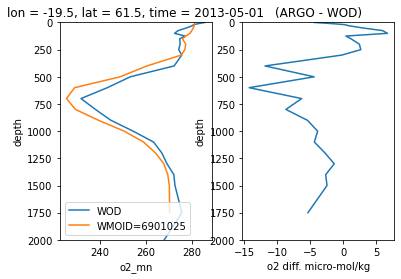

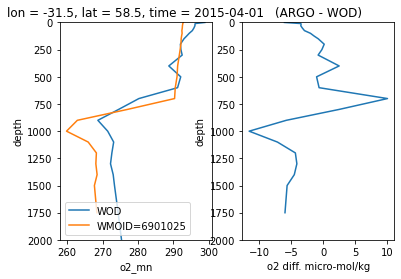

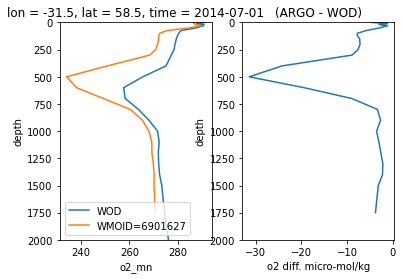

In [25]:
# match up profiles for type 3 calibration
Nty=df3.shape
o2d=np.zeros((1000,26))
Xind=[]
Yind=[]
Tind=[]
wmoid_checked=np.zeros(1000,dtype='int')
rmse=np.zeros(1000)
Ncum=0
wd0='fig_type3_matchup'
! mkdir -p fig_type3_matchup
#
for m in range(Nty[0]):
    o2diff_profiles,xloc,yloc,tloc,wmoid=match_diff(df3,m,wd0)
    Nm=np.size(xloc)
    if Nm >= 1:
        Xind.append(xloc)
        Yind.append(yloc)
        Tind.append(tloc)
        o2d[Ncum:Ncum+Nm,:]=o2diff_profiles
        rmse[Ncum:Ncum+Nm]=np.sqrt(np.nanmean(o2diff_profiles**2))
        wmoid_checked[Ncum:Ncum+Nm]=wmoid
        Ncum=Ncum+Nm

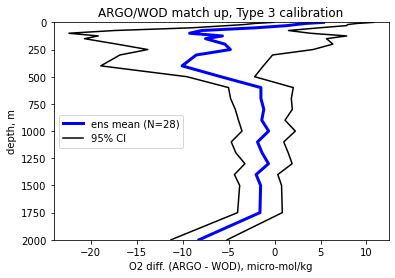

In [26]:
# save the match up results
da=xr.DataArray(data=o2d[:Ncum,:],name='o2_diff',
                dims=['profile','depth'],
               coords={'profile':range(Ncum),'depth':z[:26]})
ds=da.to_dataset()
ds.to_netcdf('Type3_matchup_o2diff.nc')
#
y=np.nanmean(o2d[:Ncum,:],axis=0)
ysd=np.nanstd(o2d[:Ncum,:],axis=0)
p0=plt.plot(y,z[:26],c='b',linewidth=3)
p1=plt.plot(y+2*ysd/np.sqrt(Ncum),z[:26],c='k')
plt.plot(y-2*ysd/np.sqrt(Ncum),z[:26],c='k')
plt.ylim(2000,0)
plt.xlabel('O2 diff. (ARGO - WOD), micro-mol/kg')
plt.ylabel('depth, m')
plt.legend([p0[0],p1[0]],['ens mean (N='+str(Ncum)+')','95% CI'])
plt.title('ARGO/WOD match up, Type 3 calibration')
plt.savefig('wod_matchup_type3.pdf',bbox_inches="tight",dpi=300)
plt.show()

In [4]:
# assemble all types together
ds1=xr.open_dataset('Type1_matchup_o2diff.nc')
ds2=xr.open_dataset('Type2_matchup_o2diff.nc')
ds3=xr.open_dataset('Type3_matchup_o2diff.nc')
#
o2d=np.concatenate((ds1.o2_diff.to_numpy(),ds2.o2_diff.to_numpy(),
                    ds3.o2_diff.to_numpy()),axis=0)
#
Nm=np.shape(o2d)
Ncum=Nm[0]
z=ds1['depth']
#
y=np.nanmean(o2d,axis=0)
print(str(np.mean(y)))
ysd=np.nanstd(o2d,axis=0,ddof=1)
#
p0=plt.plot(y,z[:26],c='b',linewidth=3)
p1=plt.plot(y+2*ysd/np.sqrt(Ncum),z[:26],c='k')
plt.plot(y-2*ysd/np.sqrt(Ncum),z[:26],c='k')
plt.ylim(2000,0)
plt.xlabel('O2 diff. (ARGO - WOD), micro-mol/kg')
plt.ylabel('depth, m')
plt.legend([p0[0],p1[0]],['ens mean (N='+str(Ncum)+')','95% CI'])
plt.title('ARGO/WOD match up, all types of calibration')
plt.savefig('wod_matchup_all.pdf',bbox_inches="tight",dpi=300)
plt.show()

-1.71822185199938


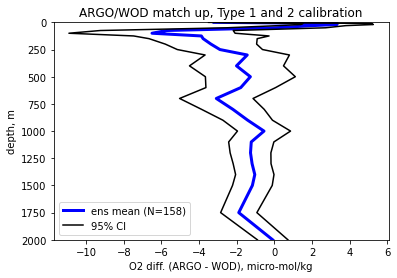

In [54]:
# assemble Type 1 and 2
#
o2d=np.concatenate((ds1.o2_diff.to_numpy(),ds2.o2_diff.to_numpy()),axis=0)
#
Nm=np.shape(o2d)
Ncum=Nm[0]
#
y=np.nanmean(o2d,axis=0)
ysd=np.nanstd(o2d,axis=0,ddof=1)
#
p0=plt.plot(y,z[:26],c='b',linewidth=3)
p1=plt.plot(y+2*ysd/np.sqrt(Ncum),z[:26],c='k')
plt.plot(y-2*ysd/np.sqrt(Ncum),z[:26],c='k')
plt.ylim(2000,0)
plt.xlabel('O2 diff. (ARGO - WOD), micro-mol/kg')
plt.ylabel('depth, m')
plt.legend([p0[0],p1[0]],['ens mean (N='+str(Ncum)+')','95% CI'])
plt.title('ARGO/WOD match up, Type 1 and 2 calibration')
plt.savefig('wod_matchup_Type12.pdf',bbox_inches="tight",dpi=300)
plt.show()